In [1]:
from daup2425p2 import *

In [2]:
fh = FileHandler("convexHullTest/file9.csv")
vp = fh.read_points()

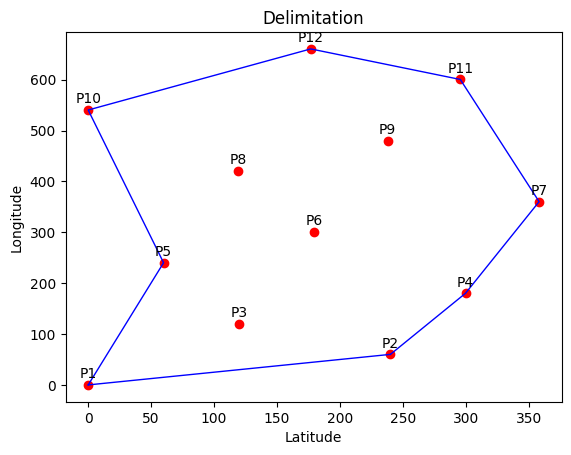

In [3]:
ap = ApproxDelimitation(vp, 400)
ap.find_delimitation().show(vp)

In [ ]:
# P1  1   5
# P2  2   3
# P3  3   7
# P4  5   5
# P5  6   2
# P6  8   6
# P7  7   8
# P8  4   1
# P9  9   3


p8 = Point("P8", 4, 1)
p5 = Point("P5", 6, 2)
p2 = Point("P2", 2, 3)

print(p8.distance(p5), p8.distance(p2), p5.distance(p2))